In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

pd.reset_option('display.max_rows')


# Importing the dataset
X_dataset = pd.read_csv('dataset_interval_four.csv')

In [2]:

X_dataset = X_dataset.drop(['Unnamed: 0', 'subject_eyeD', 'subject_id', 'eye', 'number _visits',
       'dob', 'visit_date', 'baseline_visit', 'days_from_baseline', 'visit_number'], axis = 1)

In [3]:
print(X_dataset['primary_dx'].value_counts())
print(X_dataset['gender'].value_counts())
print(X_dataset['race'].value_counts())

GL     7060
GS     2584
PDS      40
Name: primary_dx, dtype: int64
female    5612
male      4072
Name: gender, dtype: int64
white    7376
black    1824
asian     484
Name: race, dtype: int64


In [4]:
X_dataset.head()

,primary_dx,gender,race,avg_cd_ratio,gca_average,gca_tempsup,gca_sup,gca_nassup,gca_nasinf,gca_inf,...,rnfl_nassup,rnfl_nasinf,rnfl_inf,rnfl_tempinf,md,p_md,psd,p_psd,vfi,age
0,GL,male,white,0.70,66,63,61,65,71,69,...,28,35,29,20,0.372392,5,2.041738,3,94.0,64.0
1,GL,male,white,0.69,66,64,61,65,71,68,...,28,35,29,20,0.457088,3,2.588213,5,94.0,65.0
2,GL,male,white,0.72,65,63,59,65,73,67,...,25,31,28,19,0.582103,2,1.905461,3,96.0,66.0
3,GL,male,white,0.73,65,63,60,65,70,67,...,28,34,29,20,0.407380,4,2.142891,4,95.0,67.0
4,GL,male,white,0.76,54,48,53,59,57,52,...,25,25,23,18,0.141906,5,3.749730,5,83.0,63.0


In [5]:
# Encoding categorical data
from sklearn.preprocessing import LabelEncoder, StandardScaler

#label encoding dx: 3 total
labelencoder_X_1 = LabelEncoder()
X_dataset.iloc[:, 0] = labelencoder_X_1.fit_transform(X_dataset.iloc[:, 0])

#label encoding gender: 2 total
labelencoder_X_2 = LabelEncoder()
X_dataset.iloc[:, 1] = labelencoder_X_2.fit_transform(X_dataset.iloc[:, 1])

#label encoding race: 3 total
labelencoder_X_3 = LabelEncoder()
X_dataset.iloc[:, 2] = labelencoder_X_3.fit_transform(X_dataset.iloc[:, 2])

X_dataset = pd.get_dummies(X_dataset, columns=['primary_dx', 'race'], drop_first=True)


In [6]:
X = []
y_VFI = []
y_MD = []
y_RNFL = []
y_GCA = []

for i in range(0, len(X_dataset)-3, 4):
    patient = []
    #drop variables
    patient.append(X_dataset.iloc[i,:].tolist())
    patient.append(X_dataset.iloc[i+1,:].tolist())
    patient.append(X_dataset.iloc[i+2,:].tolist())
    y_VFI.append(X_dataset.loc[i+3,'vfi'].tolist())
    y_MD.append(X_dataset.loc[i+3,'md'].tolist())
    y_RNFL.append(X_dataset.loc[i+3,'rnfl_average'].tolist())
    y_GCA.append(X_dataset.loc[i+3,'gca_average'].tolist())
    X.append(patient)

In [7]:
X = np.array(X)
y_MD = np.array(y_MD)
y_GCA = np.array(y_GCA)
y_VFI = np.array(y_VFI)
y_RNFL = np.array(y_RNFL)
X.shape


(2421, 3, 26)

In [8]:
sum(y_MD)/len(y_MD)

0.6632022737892613

In [9]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout, Masking, BatchNormalization
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import StandardScaler

def lstm_baseline(X, y, name):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 200)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 200)
    
    batch_size=10
    model = Sequential()
    model.add(Masking(mask_value=9999.0))
    model.add(BatchNormalization(axis = 1))
    model.add(LSTM(128,
                   return_sequences=True,
                  ))

    model.add(LSTM(64))
    
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='relu'))
    
    #compile model
    model.compile(
        loss='mse',
        optimizer='adam',
        metrics=['mean_absolute_error'])

#     model.fit(X_train,y_train, epochs= 500)

    weight_path="LSTM_Interval_best_{}.hdf5".format(name)
    checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
    callbacks_list = [checkpoint, early_stop]
        
    #fit the model
    history = model.fit(X_train, y_train, epochs=500, validation_data=(X_val, y_val), shuffle=False, callbacks=callbacks_list, verbose=1)
    
    # plot train and validation loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model train vs validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.savefig('loss_plot_{}.png'.format(name), dpi = 300)
    plt.show()
    
    
    model.load_weights(weight_path)
    y_pred = model.predict(X_test)
    y_pred = y_pred.flatten()
    y_pred = y_pred.tolist()
    dictionary_DF = {'predicted':y_pred, 'actual':y_test}
    data = pd.DataFrame(dictionary_DF)
    data.to_csv('Predicted_vs_Actual_of_{}'.format(name))
    
    mean_absolute_error = abs(data['predicted']-data['actual'])
    mean_absolute_error = mean_absolute_error.describe()
    mean_absolute_error.to_csv('MAE_of_{}_Predicted_vs_Actual'.format(name))
    
    return model

# history = model.fit(X_train, y_train, epochs=50, batch_size=72, validation_data=(X_test, y_test), verbose=2, shuffle=False)


/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Train on 1548 samples, validate on 388 samples
Epoch 1/500
1548/1548 [==============================] - 4s 2ms/step - loss: 0.1687 - mean_absolute_error: 0.3262 - val_loss: 0.1040 - val_mean_absolute_error: 0.2471

Epoch 00001: val_loss improved from inf to 0.10396, saving model to LSTM_Interval_best_MD.hdf5
Epoch 2/500
1548/1548 [==============================] - 1s 493us/step - loss: 0.1047 - mean_absolute_error: 0.2457 - val_loss: 0.1094 - val_mean_absolute_error: 0.2367

Epoch 00002: val_loss did not improve from 0.10396
Epoch 3/500
1548/1548 [==============================] - 1s 539us/step - loss: 0.0927 - mean_absolute_error: 0.2264 - val_loss: 0.0907 - val_mean_absolute_error: 0.2145

Epoch 00003: val_loss improved from 0.10396 to 0.09073, saving model to LSTM_Interval_best_MD.hdf5
Epoch 4/500
1548/1548 [==============================] - 1s 569us/step - loss: 0.0924 - mean_absolute_error: 0.2270 - val_loss: 0.0805 - val_mean_absolute_error: 0.2020

Epoch 00004: val_loss improved

1548/1548 [==============================] - 1s 481us/step - loss: 0.0612 - mean_absolute_error: 0.1793 - val_loss: 0.0667 - val_mean_absolute_error: 0.1786

Epoch 00036: val_loss did not improve from 0.06140
Epoch 37/500
1548/1548 [==============================] - 1s 358us/step - loss: 0.0590 - mean_absolute_error: 0.1766 - val_loss: 0.0612 - val_mean_absolute_error: 0.1728

Epoch 00037: val_loss improved from 0.06140 to 0.06122, saving model to LSTM_Interval_best_MD.hdf5
Epoch 38/500
1548/1548 [==============================] - 1s 443us/step - loss: 0.0580 - mean_absolute_error: 0.1756 - val_loss: 0.0617 - val_mean_absolute_error: 0.1724

Epoch 00038: val_loss did not improve from 0.06122
Epoch 39/500
1548/1548 [==============================] - 1s 386us/step - loss: 0.0572 - mean_absolute_error: 0.1738 - val_loss: 0.0637 - val_mean_absolute_error: 0.1754

Epoch 00039: val_loss did not improve from 0.06122
Epoch 40/500
1548/1548 [==============================] - 1s 420us/step - los

1548/1548 [==============================] - 1s 395us/step - loss: 0.0413 - mean_absolute_error: 0.1480 - val_loss: 0.0571 - val_mean_absolute_error: 0.1664

Epoch 00108: val_loss did not improve from 0.05389
Epoch 109/500
1548/1548 [==============================] - 1s 402us/step - loss: 0.0443 - mean_absolute_error: 0.1519 - val_loss: 0.0535 - val_mean_absolute_error: 0.1613

Epoch 00109: val_loss improved from 0.05389 to 0.05347, saving model to LSTM_Interval_best_MD.hdf5
Epoch 110/500
1548/1548 [==============================] - 1s 417us/step - loss: 0.0419 - mean_absolute_error: 0.1474 - val_loss: 0.0553 - val_mean_absolute_error: 0.1646

Epoch 00110: val_loss did not improve from 0.05347
Epoch 111/500
1548/1548 [==============================] - 1s 399us/step - loss: 0.0426 - mean_absolute_error: 0.1485 - val_loss: 0.0560 - val_mean_absolute_error: 0.1630

Epoch 00111: val_loss did not improve from 0.05347
Epoch 112/500
1548/1548 [==============================] - 1s 401us/step -


Epoch 00143: val_loss did not improve from 0.05058
Epoch 144/500
1548/1548 [==============================] - 1s 398us/step - loss: 0.0351 - mean_absolute_error: 0.1352 - val_loss: 0.0590 - val_mean_absolute_error: 0.1652

Epoch 00144: val_loss did not improve from 0.05058
Epoch 145/500
1548/1548 [==============================] - 1s 404us/step - loss: 0.0344 - mean_absolute_error: 0.1335 - val_loss: 0.0579 - val_mean_absolute_error: 0.1628

Epoch 00145: val_loss did not improve from 0.05058
Epoch 146/500
1548/1548 [==============================] - 1s 399us/step - loss: 0.0355 - mean_absolute_error: 0.1370 - val_loss: 0.0520 - val_mean_absolute_error: 0.1557

Epoch 00146: val_loss did not improve from 0.05058
Epoch 147/500
1548/1548 [==============================] - 1s 403us/step - loss: 0.0356 - mean_absolute_error: 0.1346 - val_loss: 0.0578 - val_mean_absolute_error: 0.1636

Epoch 00147: val_loss did not improve from 0.05058
Epoch 148/500
1548/1548 [==============================]

Epoch 180/500
1548/1548 [==============================] - 1s 418us/step - loss: 0.0303 - mean_absolute_error: 0.1256 - val_loss: 0.0500 - val_mean_absolute_error: 0.1553

Epoch 00180: val_loss did not improve from 0.04825
Epoch 181/500
1548/1548 [==============================] - 1s 416us/step - loss: 0.0290 - mean_absolute_error: 0.1238 - val_loss: 0.0502 - val_mean_absolute_error: 0.1579

Epoch 00181: val_loss did not improve from 0.04825
Epoch 182/500
1548/1548 [==============================] - 1s 408us/step - loss: 0.0303 - mean_absolute_error: 0.1269 - val_loss: 0.0558 - val_mean_absolute_error: 0.1629

Epoch 00182: val_loss did not improve from 0.04825
Epoch 183/500
1548/1548 [==============================] - 1s 422us/step - loss: 0.0314 - mean_absolute_error: 0.1271 - val_loss: 0.0501 - val_mean_absolute_error: 0.1548

Epoch 00183: val_loss did not improve from 0.04825
Epoch 184/500
1548/1548 [==============================] - 1s 417us/step - loss: 0.0308 - mean_absolute_erro


Epoch 00216: val_loss did not improve from 0.04824
Epoch 217/500
1548/1548 [==============================] - 1s 401us/step - loss: 0.0268 - mean_absolute_error: 0.1176 - val_loss: 0.0542 - val_mean_absolute_error: 0.1618

Epoch 00217: val_loss did not improve from 0.04824
Epoch 218/500
1548/1548 [==============================] - 1s 385us/step - loss: 0.0249 - mean_absolute_error: 0.1138 - val_loss: 0.0550 - val_mean_absolute_error: 0.1639

Epoch 00218: val_loss did not improve from 0.04824
Epoch 219/500
1548/1548 [==============================] - 1s 403us/step - loss: 0.0264 - mean_absolute_error: 0.1169 - val_loss: 0.0562 - val_mean_absolute_error: 0.1669

Epoch 00219: val_loss did not improve from 0.04824
Epoch 220/500
1548/1548 [==============================] - 1s 406us/step - loss: 0.0283 - mean_absolute_error: 0.1225 - val_loss: 0.0536 - val_mean_absolute_error: 0.1642

Epoch 00220: val_loss did not improve from 0.04824
Epoch 221/500
1548/1548 [==============================]

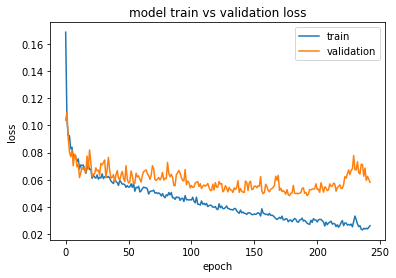

In [10]:
lstm_baseline(X, y_MD, 'MD')

Train on 1548 samples, validate on 388 samples
Epoch 1/500
1548/1548 [==============================] - 4s 2ms/step - loss: 6836.6806 - mean_absolute_error: 80.7640 - val_loss: 4790.3770 - val_mean_absolute_error: 67.0144

Epoch 00001: val_loss improved from inf to 4790.37698, saving model to LSTM_Interval_best_VFI.hdf5
Epoch 2/500
1548/1548 [==============================] - 1s 368us/step - loss: 3606.1207 - mean_absolute_error: 57.8271 - val_loss: 2118.9974 - val_mean_absolute_error: 44.1021

Epoch 00002: val_loss improved from 4790.37698 to 2118.99739, saving model to LSTM_Interval_best_VFI.hdf5
Epoch 3/500
1548/1548 [==============================] - 1s 367us/step - loss: 1423.2416 - mean_absolute_error: 35.0065 - val_loss: 662.6802 - val_mean_absolute_error: 24.0663

Epoch 00003: val_loss improved from 2118.99739 to 662.68016, saving model to LSTM_Interval_best_VFI.hdf5
Epoch 4/500
1548/1548 [==============================] - 1s 357us/step - loss: 592.4041 - mean_absolute_error: 2

1548/1548 [==============================] - 1s 354us/step - loss: 154.7706 - mean_absolute_error: 9.7478 - val_loss: 40.3570 - val_mean_absolute_error: 3.3125

Epoch 00033: val_loss did not improve from 35.48065
Epoch 34/500
1548/1548 [==============================] - 1s 356us/step - loss: 144.3113 - mean_absolute_error: 9.3208 - val_loss: 43.0297 - val_mean_absolute_error: 3.2999

Epoch 00034: val_loss did not improve from 35.48065
Epoch 35/500
1548/1548 [==============================] - 1s 358us/step - loss: 145.8016 - mean_absolute_error: 9.3251 - val_loss: 31.7422 - val_mean_absolute_error: 2.7966

Epoch 00035: val_loss improved from 35.48065 to 31.74217, saving model to LSTM_Interval_best_VFI.hdf5
Epoch 36/500
1548/1548 [==============================] - 1s 360us/step - loss: 143.6382 - mean_absolute_error: 9.3113 - val_loss: 39.0180 - val_mean_absolute_error: 2.8023

Epoch 00036: val_loss did not improve from 31.74217
Epoch 37/500
1548/1548 [==============================] - 1

1548/1548 [==============================] - 0s 311us/step - loss: 143.9349 - mean_absolute_error: 9.3892 - val_loss: 32.2373 - val_mean_absolute_error: 3.3746

Epoch 00069: val_loss did not improve from 27.70283
Epoch 70/500
1548/1548 [==============================] - 0s 320us/step - loss: 149.3709 - mean_absolute_error: 9.5771 - val_loss: 36.0804 - val_mean_absolute_error: 3.6098

Epoch 00070: val_loss did not improve from 27.70283
Epoch 71/500
1548/1548 [==============================] - 0s 317us/step - loss: 147.9193 - mean_absolute_error: 9.5494 - val_loss: 37.2435 - val_mean_absolute_error: 2.9149

Epoch 00071: val_loss did not improve from 27.70283
Epoch 72/500
1548/1548 [==============================] - 1s 335us/step - loss: 135.4062 - mean_absolute_error: 8.9344 - val_loss: 32.4201 - val_mean_absolute_error: 2.7816

Epoch 00072: val_loss did not improve from 27.70283
Epoch 73/500
1548/1548 [==============================] - 0s 322us/step - loss: 138.1136 - mean_absolute_erro

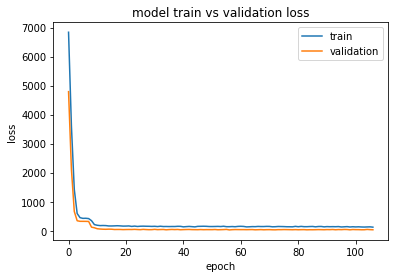

In [11]:
lstm_baseline(X, y_VFI, 'VFI')

Train on 1548 samples, validate on 388 samples
Epoch 1/500
1548/1548 [==============================] - 3s 2ms/step - loss: 4121.3787 - mean_absolute_error: 63.3122 - val_loss: 3018.5372 - val_mean_absolute_error: 54.1570

Epoch 00001: val_loss improved from inf to 3018.53720, saving model to LSTM_Interval_best_GCIPL.hdf5
Epoch 2/500
1548/1548 [==============================] - 1s 326us/step - loss: 2194.9719 - mean_absolute_error: 45.4878 - val_loss: 1337.6741 - val_mean_absolute_error: 35.3875

Epoch 00002: val_loss improved from 3018.53720 to 1337.67406, saving model to LSTM_Interval_best_GCIPL.hdf5
Epoch 3/500
1548/1548 [==============================] - 0s 322us/step - loss: 865.2865 - mean_absolute_error: 26.8280 - val_loss: 369.1698 - val_mean_absolute_error: 17.0496

Epoch 00003: val_loss improved from 1337.67406 to 369.16976, saving model to LSTM_Interval_best_GCIPL.hdf5
Epoch 4/500
1548/1548 [==============================] - 1s 337us/step - loss: 290.7293 - mean_absolute_err

1548/1548 [==============================] - 1s 330us/step - loss: 108.5634 - mean_absolute_error: 8.0637 - val_loss: 6.2158 - val_mean_absolute_error: 1.7879

Epoch 00032: val_loss did not improve from 6.17255
Epoch 33/500
1548/1548 [==============================] - 1s 337us/step - loss: 101.5658 - mean_absolute_error: 7.9218 - val_loss: 9.0509 - val_mean_absolute_error: 2.4106

Epoch 00033: val_loss did not improve from 6.17255
Epoch 34/500
1548/1548 [==============================] - 1s 345us/step - loss: 96.8005 - mean_absolute_error: 7.7736 - val_loss: 8.8963 - val_mean_absolute_error: 2.2723

Epoch 00034: val_loss did not improve from 6.17255
Epoch 35/500
1548/1548 [==============================] - 1s 365us/step - loss: 101.9670 - mean_absolute_error: 7.7965 - val_loss: 8.8836 - val_mean_absolute_error: 2.3870

Epoch 00035: val_loss did not improve from 6.17255
Epoch 36/500
1548/1548 [==============================] - 0s 323us/step - loss: 96.9404 - mean_absolute_error: 7.7888 

1548/1548 [==============================] - 0s 314us/step - loss: 93.6830 - mean_absolute_error: 7.5534 - val_loss: 4.2781 - val_mean_absolute_error: 1.4508

Epoch 00104: val_loss did not improve from 3.78224
Epoch 105/500
1548/1548 [==============================] - 0s 313us/step - loss: 98.6637 - mean_absolute_error: 7.8408 - val_loss: 9.1580 - val_mean_absolute_error: 2.5850

Epoch 00105: val_loss did not improve from 3.78224
Epoch 106/500
1548/1548 [==============================] - 1s 324us/step - loss: 98.5853 - mean_absolute_error: 7.7646 - val_loss: 8.2804 - val_mean_absolute_error: 2.3939

Epoch 00106: val_loss did not improve from 3.78224
Epoch 107/500
1548/1548 [==============================] - 0s 323us/step - loss: 96.0236 - mean_absolute_error: 7.6197 - val_loss: 5.8343 - val_mean_absolute_error: 1.7367

Epoch 00107: val_loss did not improve from 3.78224
Epoch 108/500
1548/1548 [==============================] - 0s 314us/step - loss: 89.6328 - mean_absolute_error: 7.5283


Epoch 00140: val_loss did not improve from 3.78224
Epoch 141/500
1548/1548 [==============================] - 1s 495us/step - loss: 83.6227 - mean_absolute_error: 7.1735 - val_loss: 11.0830 - val_mean_absolute_error: 2.9472

Epoch 00141: val_loss did not improve from 3.78224
Epoch 142/500
1548/1548 [==============================] - 1s 492us/step - loss: 92.5734 - mean_absolute_error: 7.5429 - val_loss: 4.6331 - val_mean_absolute_error: 1.5837

Epoch 00142: val_loss did not improve from 3.78224
Epoch 143/500
1548/1548 [==============================] - 1s 490us/step - loss: 93.8256 - mean_absolute_error: 7.6662 - val_loss: 3.2752 - val_mean_absolute_error: 1.2359

Epoch 00143: val_loss improved from 3.78224 to 3.27520, saving model to LSTM_Interval_best_GCIPL.hdf5
Epoch 144/500
1548/1548 [==============================] - 1s 439us/step - loss: 89.5716 - mean_absolute_error: 7.3771 - val_loss: 7.5045 - val_mean_absolute_error: 2.2909

Epoch 00144: val_loss did not improve from 3.27520


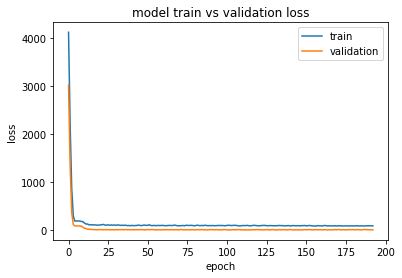

In [12]:
lstm_baseline(X, y_GCA, 'GCIPL')

Train on 1548 samples, validate on 388 samples
Epoch 1/500
1548/1548 [==============================] - 4s 3ms/step - loss: 5182.5510 - mean_absolute_error: 70.7518 - val_loss: 4173.2192 - val_mean_absolute_error: 63.3680

Epoch 00001: val_loss improved from inf to 4173.21917, saving model to LSTM_Interval_best_cRNFL.hdf5
Epoch 2/500
1548/1548 [==============================] - 0s 319us/step - loss: 3408.6906 - mean_absolute_error: 56.7524 - val_loss: 2546.3096 - val_mean_absolute_error: 48.8746

Epoch 00002: val_loss improved from 4173.21917 to 2546.30960, saving model to LSTM_Interval_best_cRNFL.hdf5
Epoch 3/500
1548/1548 [==============================] - 0s 313us/step - loss: 1910.3867 - mean_absolute_error: 41.1406 - val_loss: 1201.2806 - val_mean_absolute_error: 32.3046

Epoch 00003: val_loss improved from 2546.30960 to 1201.28064, saving model to LSTM_Interval_best_cRNFL.hdf5
Epoch 4/500
1548/1548 [==============================] - 0s 317us/step - loss: 873.7869 - mean_absolute_

1548/1548 [==============================] - 1s 496us/step - loss: 182.2110 - mean_absolute_error: 10.7544 - val_loss: 19.8285 - val_mean_absolute_error: 3.2904

Epoch 00032: val_loss did not improve from 17.92325
Epoch 33/500
1548/1548 [==============================] - 1s 497us/step - loss: 192.9187 - mean_absolute_error: 10.8387 - val_loss: 17.2846 - val_mean_absolute_error: 3.0213

Epoch 00033: val_loss improved from 17.92325 to 17.28464, saving model to LSTM_Interval_best_cRNFL.hdf5
Epoch 34/500
1548/1548 [==============================] - 1s 502us/step - loss: 173.4870 - mean_absolute_error: 10.1914 - val_loss: 23.9414 - val_mean_absolute_error: 3.7218

Epoch 00034: val_loss did not improve from 17.28464
Epoch 35/500
1548/1548 [==============================] - 1s 498us/step - loss: 184.6069 - mean_absolute_error: 10.7676 - val_loss: 16.5669 - val_mean_absolute_error: 3.0262

Epoch 00035: val_loss improved from 17.28464 to 16.56686, saving model to LSTM_Interval_best_cRNFL.hdf5
E

1548/1548 [==============================] - 1s 497us/step - loss: 171.9459 - mean_absolute_error: 10.3950 - val_loss: 13.4908 - val_mean_absolute_error: 2.6190

Epoch 00067: val_loss did not improve from 13.09740
Epoch 68/500
1548/1548 [==============================] - 1s 489us/step - loss: 174.8098 - mean_absolute_error: 10.3795 - val_loss: 14.6910 - val_mean_absolute_error: 2.7383

Epoch 00068: val_loss did not improve from 13.09740
Epoch 69/500
1548/1548 [==============================] - 1s 499us/step - loss: 175.7333 - mean_absolute_error: 10.3508 - val_loss: 12.5540 - val_mean_absolute_error: 2.4835

Epoch 00069: val_loss improved from 13.09740 to 12.55404, saving model to LSTM_Interval_best_cRNFL.hdf5
Epoch 70/500
1548/1548 [==============================] - 1s 490us/step - loss: 173.4584 - mean_absolute_error: 10.3784 - val_loss: 12.2586 - val_mean_absolute_error: 2.4435

Epoch 00070: val_loss improved from 12.55404 to 12.25861, saving model to LSTM_Interval_best_cRNFL.hdf5
E


Epoch 00101: val_loss did not improve from 10.90067
Epoch 102/500
1548/1548 [==============================] - 1s 501us/step - loss: 167.9001 - mean_absolute_error: 10.1560 - val_loss: 12.4446 - val_mean_absolute_error: 2.5869

Epoch 00102: val_loss did not improve from 10.90067
Epoch 103/500
1548/1548 [==============================] - 1s 500us/step - loss: 179.2591 - mean_absolute_error: 10.4987 - val_loss: 10.3720 - val_mean_absolute_error: 2.2079

Epoch 00103: val_loss improved from 10.90067 to 10.37202, saving model to LSTM_Interval_best_cRNFL.hdf5
Epoch 104/500
1548/1548 [==============================] - 1s 493us/step - loss: 160.8334 - mean_absolute_error: 10.0218 - val_loss: 22.4347 - val_mean_absolute_error: 3.8357

Epoch 00104: val_loss did not improve from 10.37202
Epoch 105/500
1548/1548 [==============================] - 1s 499us/step - loss: 164.6366 - mean_absolute_error: 10.0130 - val_loss: 17.1272 - val_mean_absolute_error: 3.1998

Epoch 00105: val_loss did not impro

1548/1548 [==============================] - 1s 493us/step - loss: 157.1197 - mean_absolute_error: 9.8991 - val_loss: 9.7571 - val_mean_absolute_error: 2.2377

Epoch 00173: val_loss did not improve from 9.24503
Epoch 174/500
1548/1548 [==============================] - 1s 490us/step - loss: 158.9800 - mean_absolute_error: 9.8659 - val_loss: 12.2490 - val_mean_absolute_error: 2.6150

Epoch 00174: val_loss did not improve from 9.24503
Epoch 175/500
1548/1548 [==============================] - 1s 484us/step - loss: 157.7181 - mean_absolute_error: 9.8690 - val_loss: 13.4116 - val_mean_absolute_error: 2.8270

Epoch 00175: val_loss did not improve from 9.24503
Epoch 176/500
1548/1548 [==============================] - 1s 494us/step - loss: 147.5879 - mean_absolute_error: 9.5877 - val_loss: 14.8642 - val_mean_absolute_error: 2.9468

Epoch 00176: val_loss did not improve from 9.24503
Epoch 177/500
1548/1548 [==============================] - 1s 514us/step - loss: 156.9137 - mean_absolute_error

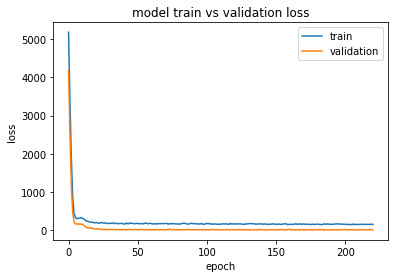

In [13]:
lstm_baseline(X, y_RNFL, 'cRNFL')